# 16.2 Sentiment Analysis: Using Recurrent Neural Networks

As a specific example illustrated in Fig. 16.2.1, we will represent each token using the pretrained GloVe model, and feed these token representations into a multilayer bidirectional RNN to obtain the text sequence representation, which will be transformed into sentiment analysis outputs (Maas et al., 2011). For the same downstream application, we will consider a different architectural choice later.

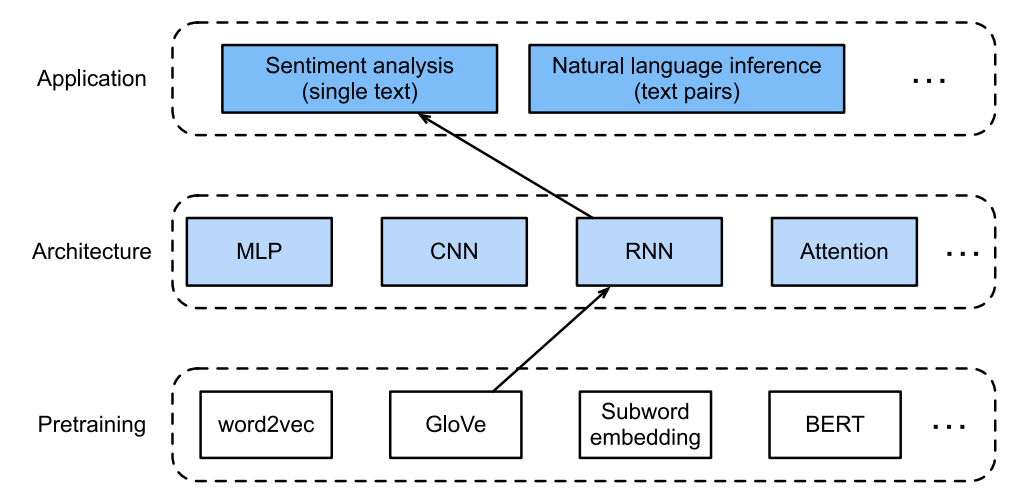

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 16.2.1 Representing Single Text with RNNs

In [2]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
        num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
        bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)
    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [3]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [4]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

## 16.2.2 Loading Pretrained Word Vectors

In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [6]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [7]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## 16.2.3 Training and Evaluating the Model

loss 0.420, train acc 0.816, test acc 0.788
1422.8 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


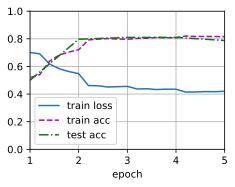

In [8]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [9]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [21]:
predict_sentiment(net, vocab, 'You are my sun shine~')

'positive'